# Setup

In [1]:
# python standard
import os

# third party
import numpy as np
import pandas as pd
import seaborn as sns
import tzlocal
from pylab import rcParams
from matplotlib import pyplot
%matplotlib inline
import rpy2.robjects as robjects

import warnings; warnings.simplefilter('ignore')

%load_ext rpy2.ipython

In [2]:
rcParams['figure.figsize'] = 22, 7
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['axes.formatter.useoffset'] = False

# Files/paths
# msg_data_path = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/bendesky/genotyping/msg/'
# lib_path = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/bendesky/genotyping/physical_map/lib'

# msg_run = os.path.join(msg_data_path, '20151111')
# combine_dir = os.path.join(msg_run, 'combine-difffac_0.1')
# rqtl_dir = os.path.join(msg_run, 'rqtl', 'EPM')

# # Files for rqtl
# cross_path = os.path.join(rqtl_dir, 'cross_EPM_newChromNames_2017.RData')
# # Files for read.cross.msg
# read_cross_file1 = os.path.join(combine_dir, 'ancestry-probs-par2.tsv.sorted.csv')
# read_cross_file2 = os.path.join(combine_dir, 'ancestry-probs-par2.tsv.sorted.pulled.converted.thinned.f2_rqtl')
# EPM_pheno_file = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/EPM/results/rqtl_epm_pheno_file.csv'
# ancfile_par1 = os.path.join(combine_dir, 'ancestry-probs-par1.tsv.sorted.pulled.converted.thinned.f2_rqtl')

cross_path = 'cross_EPM_newChromNames_2017.RData'

# Libraries
# r_package_path = os.path.join(lib_path, 'Rpackages')





# Import R Data

In [3]:
%%R
# To load qtl you must have the qtl library installed in R
library(qtl)

In [4]:
%%R -i cross_path
load(cross_path)

In [5]:
%%R
# Current Phenotypes
print(names(cross$pheno))

 [1] "id"                      "sex"                    
 [3] "frac_in_closedAndMiddle" "frac_in_closedArms"     
 [5] "frac_in_middle"          "frac_in_openArms"       
 [7] "entries_to_closed"       "entries_to_open"        
 [9] "distance_in_closed"      "distance_in_open"       
[11] "speed_in_closed"         "speed_in_open"          
[13] "entries_o_c_ratio"       "distance_o_c_ratio"     
[15] "speed_o_c_ratio"         "total_frames"           
[17] "tested_more_than_once"   "pgm"                    
[19] "frac_entries_to_open"    "frac_distance_in_open"  
[21] "log_temp_pheno"         


# Merge R Data with New Features

In [6]:
miceDF = robjects.r('cross$pheno')
miceDF = robjects.pandas2ri.ri2py_dataframe(miceDF)

def extractNumber(mouseIDString):
    indexStart = 5
    indexEnd = mouseIDString.find('_')
    return int(mouseIDString[indexStart:indexEnd])

miceDF['mouseID'] = miceDF['id'].apply(lambda mouseIDString: extractNumber(mouseIDString))
miceDF['mouseID'] = pd.to_numeric(miceDF['mouseID'])


newFeaturesPath = 'all_the_data.csv'
newFeaturesDF = pd.read_csv(newFeaturesPath, index_col=0)
newFeaturesDF['mouse_details_mouseID'] = pd.to_numeric(newFeaturesDF['mouse_details_mouseID'])
# newFeaturesDF = newFeaturesDF.set_index('mouse_details_mouseID', inplace=False)

# Drop duplicate mouse IDs in new features
newFeaturesDF = newFeaturesDF.drop_duplicates(subset='mouse_details_mouseID')

mergedDF = pd.merge(
    miceDF, 
    newFeaturesDF, 
    left_on='mouseID', 
    right_on='mouse_details_mouseID',
    how='left'
)

cross_R_DF = robjects.pandas2ri.py2ri(mergedDF)

In [7]:
# type(miceDF['mouseID'][0])

In [8]:
# type(newFeaturesDF['mouse_details_mouseID'][0])

In [9]:
# for value in newFeaturesDF['mouse_details_mouseID']:
#     print(value)

In [10]:
# ids = newFeaturesDF["mouse_details_mouseID"]
# newFeaturesDF = newFeaturesDF.drop_duplicates(subset='mouse_details_mouseID')
# ids2 = newFeaturesDF["mouse_details_mouseID"]

In [11]:
# len(ids)

In [12]:
# len(ids2)

In [13]:
print(cross_R_DF.names)

  [1] "id"                                                                  
  [2] "sex"                                                                 
  [3] "frac_in_closedAndMiddle"                                             
  [4] "frac_in_closedArms"                                                  
  [5] "frac_in_middle"                                                      
  [6] "frac_in_openArms"                                                    
  [7] "entries_to_closed"                                                   
  [8] "entries_to_open"                                                     
  [9] "distance_in_closed"                                                  
 [10] "distance_in_open"                                                    
 [11] "speed_in_closed"                                                     
 [12] "speed_in_open"                                                       
 [13] "entries_o_c_ratio"                                                   

In [14]:
goodFeaturesSpecies = [
    'fraction_in_arms_closed', 
    'fraction_in_arms_middle',
    'fraction_in_arms_open', 
    'mouse_dimensions_mouseLength',
    'mouse_dimensions_mouseWidth',
    'mouse_dimensions_mouseSize',
    'peeking_fraction_total',
    'rest_fraction_all_arms',
    'rest_fraction_closed_arms', 
    'rest_fraction_open_arms',
    'turning_preferences_fraction_back',
    'turning_preferences_fraction_left',
    'turning_preferences_fraction_right',
    'turning_preferences_fraction_straight',
    'velocity_closed_towards_outside_average_speed_active',
    'velocity_open_towards_middle_average_speed_active',
    'velocity_open_towards_outside_average_speed_active'
]

goodFeaturesSex = [
    'fraction_in_arms_closed', 
    'fraction_in_arms_open',
    'velocity_open_towards_outside_average_speed_active'
]

goodFeaturesSpeciesSex = [
    'peeking_fraction_total', 
    'safety_fraction_closed_arms', 
    'turning_preferences_fraction_left'
]

goodFeaturesAll = []
goodFeaturesAll.extend(goodFeaturesSpecies)
goodFeaturesAll.extend(goodFeaturesSex)
goodFeaturesAll.extend(goodFeaturesSpeciesSex)
goodFeaturesAll = list(set(goodFeaturesAll))
goodFeaturesAll.sort()

In [45]:
print(goodFeaturesAll)

['rest_fraction_all_arms', 'velocity_open_towards_middle_average_speed_active', 'safety_fraction_closed_arms', 'turning_preferences_fraction_right', 'fraction_in_arms_closed', 'fraction_in_arms_open', 'turning_preferences_fraction_straight', 'mouse_dimensions_mouseSize', 'velocity_open_towards_outside_average_speed_active', 'mouse_dimensions_mouseLength', 'peeking_fraction_total', 'turning_preferences_fraction_back', 'fraction_in_arms_middle', 'turning_preferences_fraction_left', 'rest_fraction_closed_arms', 'mouse_dimensions_mouseWidth', 'velocity_closed_towards_outside_average_speed_active', 'rest_fraction_open_arms']


In [15]:
goodFeaturesSpeciesWithoutDimensions = [
    'fraction_in_arms_closed', 
    'fraction_in_arms_middle',
    'fraction_in_arms_open',
    'peeking_fraction_total',
    'rest_fraction_all_arms',
    'rest_fraction_closed_arms', 
    'rest_fraction_open_arms',
    'turning_preferences_fraction_back',
    'turning_preferences_fraction_left',
    'turning_preferences_fraction_right',
    'turning_preferences_fraction_straight',
    'velocity_closed_towards_outside_average_speed_active',
    'velocity_open_towards_middle_average_speed_active',
    'velocity_open_towards_outside_average_speed_active'
]

In [16]:
%%R -i goodFeaturesSpecies,goodFeaturesSex,goodFeaturesSpeciesSex,goodFeaturesAll,cross_R_DF
goodFeaturesSpecies <- goodFeaturesSpecies
goodFeaturesSex <- goodFeaturesSex
goodFeaturesSpeciesSex <- goodFeaturesSpeciesSex
goodFeaturesAll <- goodFeaturesAll
for (feature in goodFeaturesAll){
    cross$pheno[,feature] <- as.numeric(cross_R_DF[,feature])
}

In [17]:
%%R
print(summary(cross))

    F2 intercross

    No. individuals:    1571 

    No. phenotypes:     39 
    Percent phenotyped: 99 

    No. chromosomes:    24 
        Autosomes:      1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
                        23 
        X chr:          X 

    Total markers:      51739 
    No. markers:        3680 2706 3346 3181 3273 2538 2402 2543 2012 1806 2183 
                        1950 1134 1704 1529 1786 938 1543 1309 1853 2228 1588 
                        1647 2860 
    Percent genotyped:  99.1 
    Genotypes (%):    
          Autosomes:        AA:23.6      AB:51.6      BB:24.8  not BB:0.0  
                        not AA:0.0  
       X chromosome:        AA:21.3     ABf:19.7     ABr:6.2       BB:0.4  
                            AY:24.1      BY:28.3 


In [18]:
%%R
# All the phenotypes we have now
print(names(cross$pheno))

 [1] "id"                                                  
 [2] "sex"                                                 
 [3] "frac_in_closedAndMiddle"                             
 [4] "frac_in_closedArms"                                  
 [5] "frac_in_middle"                                      
 [6] "frac_in_openArms"                                    
 [7] "entries_to_closed"                                   
 [8] "entries_to_open"                                     
 [9] "distance_in_closed"                                  
[10] "distance_in_open"                                    
[11] "speed_in_closed"                                     
[12] "speed_in_open"                                       
[13] "entries_o_c_ratio"                                   
[14] "distance_o_c_ratio"                                  
[15] "speed_o_c_ratio"                                     
[16] "total_frames"                                        
[17] "tested_more_than_once"            

### Make sure code was matched up correctly

In [19]:
mergedDF.columns.values

array(['id', 'sex', 'frac_in_closedAndMiddle', 'frac_in_closedArms',
       'frac_in_middle', 'frac_in_openArms', 'entries_to_closed',
       'entries_to_open', 'distance_in_closed', 'distance_in_open',
       'speed_in_closed', 'speed_in_open', 'entries_o_c_ratio',
       'distance_o_c_ratio', 'speed_o_c_ratio', 'total_frames',
       'tested_more_than_once', 'pgm', 'frac_entries_to_open',
       'frac_distance_in_open', 'log_temp_pheno', 'mouseID',
       'backtrack_counts_CL', 'backtrack_counts_CR',
       'backtrack_counts_OB', 'backtrack_counts_OT',
       'backtrack_counts_total', 'backtrack_counts_total_closed',
       'backtrack_counts_total_open', 'fraction_in_arms_bottom',
       'fraction_in_arms_closed', 'fraction_in_arms_closed_and_middle',
       'fraction_in_arms_left', 'fraction_in_arms_middle',
       'fraction_in_arms_open', 'fraction_in_arms_right',
       'fraction_in_arms_top', 'frames_in_arms_CL', 'frames_in_arms_CR',
       'frames_in_arms_M', 'frames_in_arms_OB'

In [20]:
compareDF = mergedDF[['id', 'frac_in_closedArms', 'fraction_in_arms_closed']]
compareDF

,id,frac_in_closedArms,fraction_in_arms_closed
0,indiv767_DUMMY,0.805050,0.845120
1,indiv768_DUMMY,0.907493,0.618140
2,indiv769_DUMMY,0.540040,0.862334
3,indiv770_DUMMY,0.638178,0.775361
4,indiv771_DUMMY,0.733981,0.788999
5,indiv772_DUMMY,0.481372,0.805709
6,indiv795_DUMMY,0.977885,0.997525
7,indiv796_DUMMY,0.913033,0.933473
8,indiv797_DUMMY,0.637464,NaN
9,indiv798_DUMMY,0.859972,0.867263


In [21]:
compareDF = mergedDF[['id', 'frac_in_closedArms', 'fraction_in_arms_closed']].dropna()
compareDF['mouseID'] = compareDF['id'].apply(lambda mouseIDString: extractNumber(mouseIDString))
miceToCompare = [767, 840, 4104, 4133]
compareDF.loc[compareDF['mouseID'].isin(miceToCompare)]

,id,frac_in_closedArms,fraction_in_arms_closed,mouseID
0,indiv767_DUMMY,0.805050,0.845120,767
22,indiv840_DUMMY,0.926847,0.934268,840
873,indiv4104_DUMMY,0.776789,0.793784,4104
884,indiv4133_DUMMY,0.632931,0.665328,4133


In [22]:
miceToCompare = [str(mouseID) for mouseID in miceToCompare]
compareDF2 = newFeaturesDF[['mouse_details_mouseID', 'fraction_in_arms_closed']].dropna()
compareDF2.loc[compareDF2['mouse_details_mouseID'].isin(miceToCompare)]

,mouse_details_mouseID,fraction_in_arms_closed
2,767,0.845120
64,840,0.934268
1028,4104,0.793784
1037,4133,0.665328


### Remove Markers Near Ends of Chromosomes

In [23]:
# %%R
# print(summary(cross))

In [24]:
%%R
# removeOuterMarkers <- function(cross) {
#     chroms <- c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
#                 '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                 '20', '21', '22', '23', 'X')

#     for (chrom in chroms) {
#         window <- 15
#         markerNameList <- markernames(cross, chrom)
#         numMarkers <- length(markerNameList)
        
#         firstWindow <- markerNameList[1:window]
#         lastWindow <- markerNameList[(numMarkers - window + 1):(numMarkers)]
        
#         cross <- drop.markers(cross, firstWindow)
#         cross <- drop.markers(cross, lastWindow)
#     }
    
#     cross <- clean(cross)
#     return(cross)
# }

# cross <- removeOuterMarkers(cross)

NULL


In [25]:
%%R
removeOuterMarkers <- function(scanoneResult) {
    chroms <- c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                '11', '12', '13', '14', '15', '16', '17', '18', '19', 
                '20', '21', '22', '23', 'X')

    currentSpot <- 1
    window <- 15
    
    scanoneResult$'chr'[1:10] <- NA
    
    for (chrom in chroms) {
        
        numMarkers <- length(cross$geno[[chrom]]$map)
        
        currentSpot <- currentSpot + numMarkers
        if (chrom == 'X') {
            scanoneResult$'chr'[(currentSpot - window):(currentSpot-1)] <- NA
        } else {
            scanoneResult$'chr'[(currentSpot - window - 1):(currentSpot + window - 1)] <- NA
        }
    }
    scanoneResult <- na.omit(scanoneResult)
    return(scanoneResult)
}

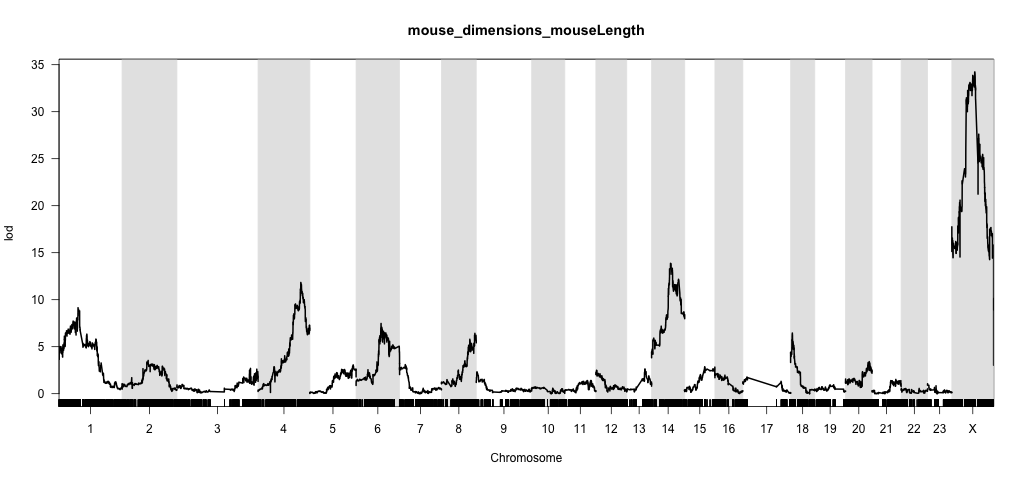

In [26]:
%%R -w 1024
featureNP <- scanone(cross,pheno="mouse_dimensions_mouseLength",model='np')
featureNP <- removeOuterMarkers(featureNP)
plot(featureNP, bandcol = "gray90", main="mouse_dimensions_mouseLength")


In [27]:
%%R
print(length(cross$geno$"1"$map))

[1] 3680


# Basic QTL

### Ensure code is working the same as before

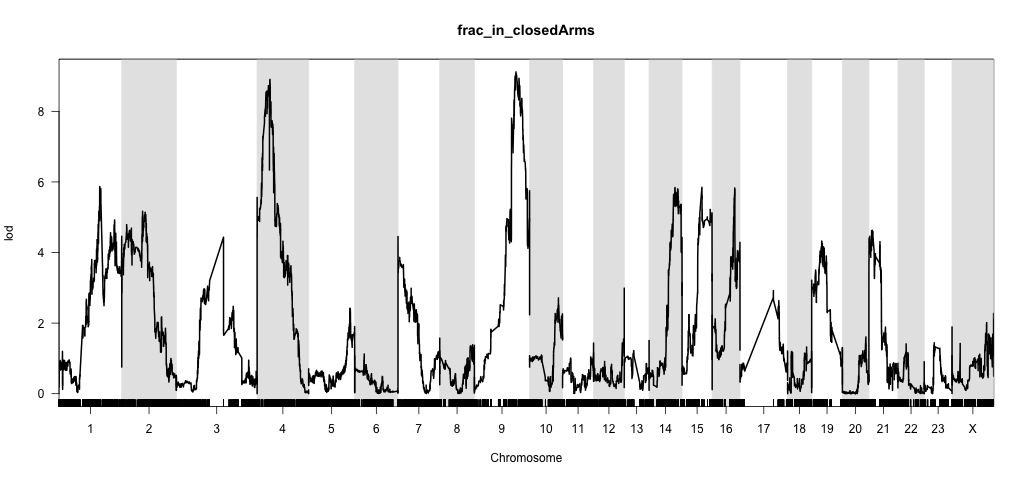

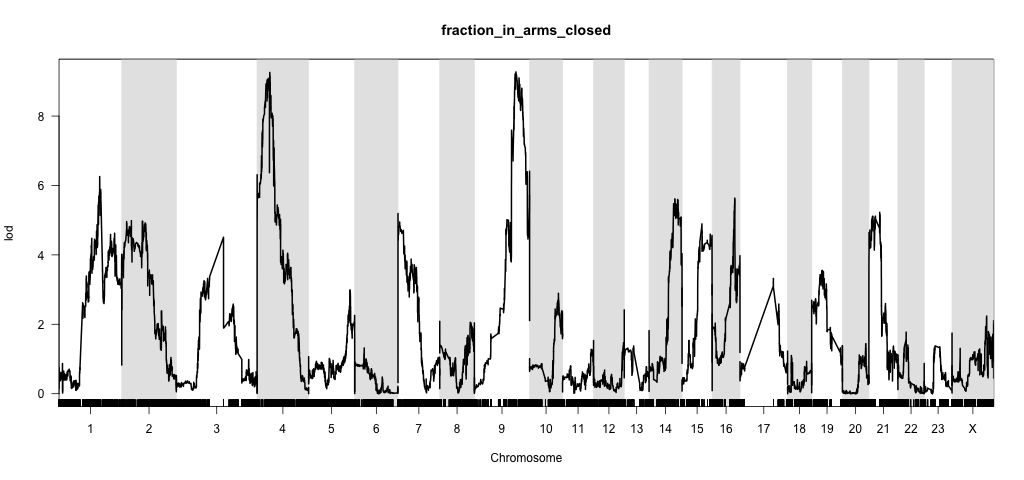

In [28]:
%%R -w 1024

fraction_open_np <- scanone(cross,pheno="frac_in_closedArms",model='np')
plot(fraction_open_np, bandcol = "gray90", main="frac_in_closedArms")

featureNP <- scanone(cross,pheno="fraction_in_arms_closed",model='np')
plot(featureNP, bandcol = "gray90", main="fraction_in_arms_closed")


### Run QTL and Save Off Plots

In [29]:
%%R
for (feature in goodFeaturesAll) {
    print(feature)
    featureNP <- scanone(cross,pheno=feature,model='np')
    featureNP <- removeOuterMarkers(featureNP)
    pdf(paste('results/', feature,'.pdf', sep=""), width=10, height=5)
    plot(featureNP, bandcol = "gray90", main=feature)
    dev.off()
}

[1] "rest_fraction_all_arms"
[1] "velocity_open_towards_middle_average_speed_active"
[1] "safety_fraction_closed_arms"
[1] "turning_preferences_fraction_right"
[1] "fraction_in_arms_closed"
[1] "fraction_in_arms_open"
[1] "turning_preferences_fraction_straight"
[1] "mouse_dimensions_mouseSize"
[1] "velocity_open_towards_outside_average_speed_active"
[1] "mouse_dimensions_mouseLength"
[1] "peeking_fraction_total"
[1] "turning_preferences_fraction_back"
[1] "fraction_in_arms_middle"
[1] "turning_preferences_fraction_left"
[1] "rest_fraction_closed_arms"
[1] "mouse_dimensions_mouseWidth"
[1] "velocity_closed_towards_outside_average_speed_active"
[1] "rest_fraction_open_arms"


# Create Heatmap

### By Species

In [30]:
def scanone_pheno(pheno):
    scanone_cmd = '''
        tryCatch({
            model <- "np"
            method <- NULL
            scanName <- model
            # scanone
            out <- scanone(cross, pheno="%s", model=model, method=method)
            out <- removeOuterMarkers(out)
            # Add results to list
            maleAndFemale_scanone[["%s"]][[scanName]]$out <- out
            }, error = function(err) {
                rm(out)
                print(paste("%s", err))
        })
        ''' % tuple([pheno for i in range(3)])
    return scanone_cmd

def do_scanone(scanone_cmd):
    robjects.r(scanone_cmd)

In [31]:
%%R
maleAndFemale_scanone <- list()

In [40]:
for p in goodFeaturesSpecies:
    #skip phenotype if it has already been analyzed
    if robjects.r('"out" %%in%% names(maleAndFemale_scanone$%s$np)' % p)[0]:
        print (p, 'done')
        continue
    print('Working on', p)
    scanone_cmd = scanone_pheno(p)
    do_scanone(scanone_cmd)
    print('Done with', p)
    
robjects.r('save.image("%s")' % 'updatedRDatabase.RData')

fraction_in_arms_closed done
fraction_in_arms_middle done
fraction_in_arms_open done
Working on mouse_dimensions_mouseLength
Done with mouse_dimensions_mouseLength
Working on mouse_dimensions_mouseWidth
Done with mouse_dimensions_mouseWidth
Working on mouse_dimensions_mouseSize
Done with mouse_dimensions_mouseSize
peeking_fraction_total done
rest_fraction_all_arms done
rest_fraction_closed_arms done
rest_fraction_open_arms done
turning_preferences_fraction_back done
turning_preferences_fraction_left done
turning_preferences_fraction_right done
turning_preferences_fraction_straight done
velocity_closed_towards_outside_average_speed_active done
velocity_open_towards_middle_average_speed_active done
velocity_open_towards_outside_average_speed_active done


rpy2.rinterface.NULL

In [41]:
lods = []
for pheno in goodFeaturesSpecies:
    r_cmd = '''
        summary(maleAndFemale_scanone$%s$np$out,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    lods.extend(qtl.iloc[:,2].tolist())

max_lod = sorted(lods)[-1]

max_lod

34.57454154796892

In [42]:
for lod in lods:
    print(lod)

6.2576942341686435
4.986314119256393
4.509268883278438
9.25808859244975
4.947228787019919
9.272590004602021
5.616028265884555
4.893148009093625
5.635370949945626
5.226425174392522
5.823760273919327
6.054102811427856
7.276208892893217
4.201568573091722
5.507407045318551
5.06741158956613
11.005127995404356
4.233832716258029
8.424034895055803
6.440596894844115
5.405431433743158
5.647961018852514
4.629512867951374
4.096569710663324
5.786726611351758
9.146468280970383
11.836118406778898
7.472076358830797
6.422649922808435
13.870835162326406
6.454197285879404
34.23194680173362
4.1139353809946275
12.906155609580741
4.781934171599272
5.325398801251672
6.485198606777913
4.0311793774922915
25.988467727216296
6.4876015021546225
14.686292886123102
4.876282907536481
6.117148674277732
10.419834294341538
34.57454154796892
4.004774418655979
4.348039487104636
5.957251008125435
4.285030758650297
4.109838270449131
6.016027892631752
5.67018118194763
5.036597479950054
4.506481910715082
5.967756360093856
5.

In [43]:
qtls = {pheno:[] for pheno in goodFeaturesSpecies}

for pheno in goodFeaturesSpecies:
    r_cmd = '''
        summary(maleAndFemale_scanone$%s$np$out,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    qtls[pheno] = [(row['chr'],int(row['pos'])) for index,row in qtl.iterrows()]

bayes_prob = 0.95

for pheno,qtl in qtls.items():
    new_qtl_info = []
    for chrom,pos in qtl:
        r_cmd = 'bayesint(maleAndFemale_scanone$%s$np$out, chr="%s", prob=%s)' % (pheno, chrom, bayes_prob)
        bayes_int = robjects.r(r_cmd)
        bayes_int = robjects.pandas2ri.ri2py_dataframe(bayes_int)
        qtl_left_end = int(bayes_int.iloc[0,1])
        qtl_peak = int(bayes_int.iloc[1,1])
        qtl_right_end = int(bayes_int.iloc[2,1])
        new_qtl_info.append((chrom, qtl_left_end, qtl_peak, qtl_right_end))
    qtls[pheno] = new_qtl_info

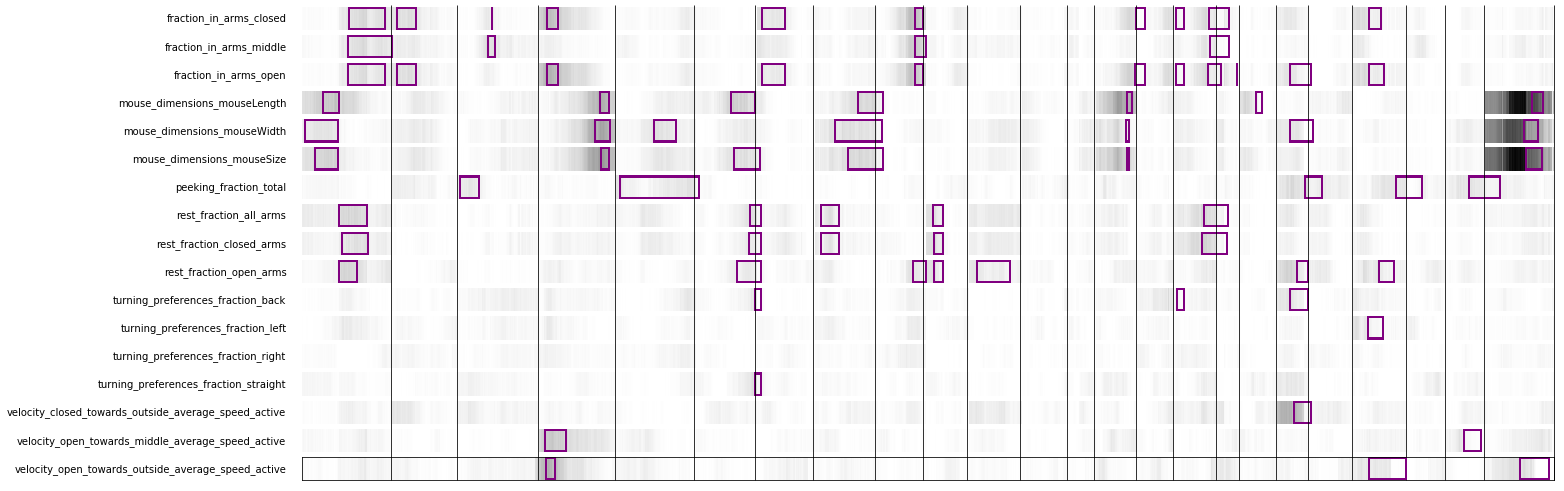

In [44]:
nrows = len(goodFeaturesSpecies)

def plot_axis(ax, lods, pheno):
    gradient = np.vstack((lods, lods))
#     ax.imshow(gradient, aspect='auto', cmap='Greys', vmin=0, vmax=np.ceil(max_lod))
    ax.imshow(gradient, aspect='auto', cmap='binary', vmin=0, vmax=np.ceil(max_lod))
    pos = list(ax.get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    fig.text(x_text, y_text, pheno, va='center', ha='right', fontsize=10)

def plot_QTL_interval(ax, bayesint):
    '''
    Draws a box at the QTL bayes support interval 
    '''
    ax.autoscale(False)
    ax.axvline(x=bayesint[0], linewidth=2, color='purple')
    ax.axvline(x=bayesint[1], linewidth=2, color='purple')
    ymin, ymax = pyplot.ylim()
    ax.hlines([-0.48,1.48], bayesint[0], bayesint[1], colors='purple', linewidth=4)
    
def marker_in_genome_from_pos_in_chrom(chrom,pos_in_chrom):
    first_marker = list(robjects.r('markernames(cross, "%s")' % chrom))[0]
    # Because I changed the chromosome names, markers in some chromosomes now don't match the name of the chromosome,
    # so we need this hack
    marker_chrom_name = first_marker.split(':')[0]
    marker_pos_in_chrom = list(robjects.r('markernames(cross, "%s")' % chrom)).index(marker_chrom_name+':'+str(pos_in_chrom))
    if chrom == '1':
        marker_pos_in_genome = marker_pos_in_chrom 
    else:
        marker_pos_in_genome = marker_pos_in_chrom + chrom_starts[chrom_names[chrom_names.index(chrom)-1]]
    return marker_pos_in_genome

# Demarcate edges of chromosomes
chr_edges = []
markers_per_chrom = list(robjects.r('nmar(cross)'))
edge = 0
for chrom in markers_per_chrom:
    edge += chrom
    chr_edges.append(edge)
# np.array(chr_edges)
chrom_names = list(robjects.r('chrnames(cross)'))
chrom_starts = dict(zip(chrom_names,chr_edges))
    
fig, axes = pyplot.subplots(nrows=nrows)
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)

for i,pheno in enumerate(goodFeaturesSpecies):
    # Get scanone data
    r_cmd = 'maleAndFemale_scanone$%s$np$out' % pheno
    scanoneDF = robjects.r(r_cmd)
    scanoneDF = robjects.pandas2ri.ri2py_dataframe(scanoneDF)
    lods = np.array(scanoneDF.iloc[:,2])
    plot_axis(axes[i], lods, pheno)

    # Get bayes support interval
    for qtl in qtls[pheno]:
        chrom = qtl[0]
        qtl_left_end, qtl_right_end = qtl[1], qtl[3]
        left_pos_in_plot = marker_in_genome_from_pos_in_chrom(chrom,qtl_left_end)
        right_pos_in_plot = marker_in_genome_from_pos_in_chrom(chrom,qtl_right_end)
        plot_QTL_interval(axes[i], (left_pos_in_plot,right_pos_in_plot))

for ax in axes:
    ax.set_axis_off()

ax.set_axis_on()

# Remove horizontal white lines
ax.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off',
    labelleft='off')
ax.yaxis.grid(False)

# Plot chromosome borders
ax.set_xticks(chr_edges)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    direction='in',
    length=475,
    labelbottom='off',
    top='off',)         # ticks along the top edge are off

# Save figure
pyplot.savefig('results/qtls_sexesCombined_heatMap_20170123.pdf')

### By Gender

In [ ]:
%%R
y <- pull.pheno(cross, 2)
males <- subset(cross, ind = (y == 'M'))
females <- subset(cross, ind = (y == 'F'))

In [ ]:
def scanone_pheno(pheno):
    scanone_cmd = '''
        tryCatch({
            model <- "np"
            method <- NULL
            scanName <- model
            # scanone
            out.males <- scanone(males, pheno="%s", model=model, method=method)
            out.females <- scanone(females, pheno="%s", model=model, method=method)
            out.males <- removeOuterMarkers(out.males)
            out.females <- removeOuterMarkers(out.females)

            # Add results to list
            bySex_scanone[["%s"]][[scanName]]$out$males <- out.males
            bySex_scanone[["%s"]][[scanName]]$out$females <- out.females
            }, error = function(err) {
                rm(out.males,out.females)
                print(paste("%s", err))
        })
        ''' % tuple([pheno for i in range(5)])
    return scanone_cmd

def do_scanone(scanone_cmd):
    robjects.r(scanone_cmd)

In [ ]:
%%R
bySex_scanone <- list()

In [ ]:
for p in goodFeaturesAll:
    #skip phenotype if it has already been analyzed
    if robjects.r('"out" %%in%% names(bySex_scanone$%s$np)' % p)[0]:
        print(p, 'done')
        continue
    print('Working on', p)
    scanone_cmd = scanone_pheno(p)
    do_scanone(scanone_cmd)
#     robjects.r('save.image("%s")' % cross_path)
    print('Done with', p)

In [ ]:
%%R
print(bySex_scanone)

In [ ]:
alpha = 0.05

qtls = {'males':None, 'females':None}
qtls['males'] = {pheno:[] for pheno in goodFeaturesAll}
qtls['females'] = {pheno:[] for pheno in goodFeaturesAll}
for pheno in goodFeaturesAll:
    # Males
    r_cmd = '''
        summary(bySex_scanone$%s$np$out$males,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    qtls['males'][pheno] = [(row['chr'],int(row['pos'])) for index,row in qtl.iterrows()]
    
    # Females
    r_cmd = '''
        summary(bySex_scanone$%s$np$out$females,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    qtls['females'][pheno] = [(row['chr'],int(row['pos'])) for index,row in qtl.iterrows()]
    
bayes_prob = 0.95    

# qtl coordinates (chromosome, start, peak, end)
# qtl = ('3',30308454,64243045,80696262)
for sex,pheno_qtls in qtls.items():
    for pheno,qtl in pheno_qtls.items():
        new_qtl_info = []
        for q in qtl:
            chrom = q[0]
            r_cmd = 'bayesint(bySex_scanone$%s$np$out$%s, chr="%s", prob=%s)' % (pheno, sex, chrom, bayes_prob)
            bayes_int = robjects.r(r_cmd)
            bayes_int = robjects.pandas2ri.ri2py_dataframe(bayes_int)
            qtl_left_end = int(bayes_int.iloc[0,1])
            qtl_peak = int(bayes_int.iloc[1,1])
            qtl_right_end = int(bayes_int.iloc[2,1])
            new_qtl_info.append((chrom, qtl_left_end, qtl_peak, qtl_right_end))
        qtls[sex][pheno] = new_qtl_info

In [ ]:
lods = []
for pheno in goodFeaturesAll:
    # Males
    r_cmd = '''
        summary(bySex_scanone$%s$np$out$males,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    lods.extend(qtl.iloc[:,2].tolist())

    # Females
    r_cmd = '''
        summary(bySex_scanone$%s$np$out$females,
        threshold=4)
        ''' % (pheno)
    qtl = robjects.r(r_cmd)
    qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
    lods.extend(qtl.iloc[:,2].tolist())

max_lod = sorted(lods)[-1]

max_lod

In [ ]:
nrows = len(goodFeaturesAll)*2 # *2 for the two sexes

def plot_axis(ax, lods, pheno, sex):
    gradient = np.vstack((lods, lods))
    sex_cmaps = {'female':'Reds', 'male':'Blues'}
    ax.imshow(gradient, aspect='auto', cmap=sex_cmaps[sex], vmin=0, vmax=np.ceil(max_lod))
    pos = list(ax.get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    fig.text(x_text, y_text, pheno, va='center', ha='right', fontsize=10)

def plot_QTL_interval(ax, bayesint):
    '''
    Draws a box at the QTL bayes support interval 
    '''
    ax.autoscale(False)
    ax.axvline(x=bayesint[0], linewidth=2, color='black')
    ax.axvline(x=bayesint[1], linewidth=2, color='black')
    ymin, ymax = pyplot.ylim()
    ax.hlines([-0.48,1.48], bayesint[0], bayesint[1], colors='black', linewidth=2)

def marker_in_genome_from_pos_in_chrom(chrom,pos_in_chrom):
    first_marker = list(robjects.r('markernames(cross, "%s")' % chrom))[0]
    # Because I changed the chromosome names, markers in some chromosomes now don't match the name of the chromosome,
    # so we need this hack
    marker_chrom_name = first_marker.split(':')[0]
    marker_pos_in_chrom = list(robjects.r('markernames(cross, "%s")' % chrom)).index(marker_chrom_name+':'+str(pos_in_chrom))
    if chrom == '1':
        marker_pos_in_genome = marker_pos_in_chrom 
    else:
        marker_pos_in_genome = marker_pos_in_chrom + chrom_starts[chrom_names[chrom_names.index(chrom)-1]]
    return marker_pos_in_genome

# Demarcate edges of chromosomes
chr_edges = []
markers_per_chrom = list(robjects.r('nmar(cross)'))
edge = 0
for chrom in markers_per_chrom:
    edge += chrom
    chr_edges.append(edge)
# np.array(chr_edges)
chrom_names = list(robjects.r('chrnames(cross)'))
chrom_starts = dict(zip(chrom_names,chr_edges))
    
fig, axes = pyplot.subplots(nrows=nrows)
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)

i = 0
for pheno in goodFeaturesAll:
    for sex in ['male','female']:
        # Get scanone data
        r_cmd = 'bySex_scanone$%s$np$out$%s' % (pheno,sex)
        qtl = robjects.r(r_cmd)
        qtl = robjects.pandas2ri.ri2py_dataframe(qtl)
        lods = np.array(qtl.iloc[:,2])
        plot_axis(axes[i], lods, pheno, sex)
        
        # Get bayes support interval
        for qtl in qtls[sex+'s'][pheno]:
            chrom = qtl[0]
            qtl_left_end, qtl_right_end = qtl[1], qtl[3]
            left_pos_in_plot = marker_in_genome_from_pos_in_chrom(chrom,qtl_left_end)
            right_pos_in_plot = marker_in_genome_from_pos_in_chrom(chrom,qtl_right_end)
            plot_QTL_interval(axes[i], (left_pos_in_plot,right_pos_in_plot))
        i += 1

for ax in axes:
    ax.set_axis_off() 

ax.set_axis_on()

# Remove horizontal white lines
ax.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off',
    labelleft='off')
ax.yaxis.grid(False)

# Plot chromosome borders
ax.set_xticks(chr_edges)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    direction='in',
    length=475,
    labelbottom='off',
    top='off',)         # ticks along the top edge are off

# Save figure
pyplot.savefig('results/by_sex_qtls_3d_plot_20180327.pdf')